In [1]:
import sys
sys.path.append('../')

import numpy as np
#from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
#from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import ResNet50

from tensorflow.nn import depthwise_conv2d, relu
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

/home/liam/anaconda3/envs/lam/lib/python3.10/site-packages/skimage/filters/edges.py:2: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy import ndimage as ndi
2025-08-25 13:18:21.259736: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-25 13:18:21.282643: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-25 13:18:21.282665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-25 13:18:21.283429: E external/local_xla/x

#### Experiment #1 : Confirming that most energy lies within the first 3 DCT coeficients

In [2]:
model = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

2025-08-25 13:18:22.296346: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-25 13:18:22.334991: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-25 13:18:22.336515: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		if l.kernel_size == (3,3):
			conv_layers.append(l)


In [4]:
len(conv_layers)

16

(64, 3, 3, 64) (64, 3, 3, 64) (64, 3, 3, 64)
(64, 3, 3, 64) (64, 3, 3, 64) (64, 3, 3, 64)


/tmp/ipykernel_23891/2633451856.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[l_num+1].set_xticklabels([''] * ws.shape[0])  # Set empty labels
/tmp/ipykernel_23891/2633451856.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[l_num+1].set_xticklabels([''] * ws.shape[0])  # Set empty labels
/tmp/ipykernel_23891/2633451856.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[l_num+1].set_xticklabels([''] * ws.shape[0])  # Set empty labels
/tmp/ipykernel_23891/2633451856.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[l_num+1].set_xticklabels([''] * ws.shape[0])  # Set empty labels
/tmp/ipykernel_23891/2633451856.py:77: UserWarni

(64, 3, 3, 64) (64, 3, 3, 64) (64, 3, 3, 64)
(128, 3, 3, 128) (128, 3, 3, 128) (128, 3, 3, 128)
(128, 3, 3, 128) (128, 3, 3, 128) (128, 3, 3, 128)
(128, 3, 3, 128) (128, 3, 3, 128) (128, 3, 3, 128)
(128, 3, 3, 128) (128, 3, 3, 128) (128, 3, 3, 128)
(256, 3, 3, 256) (256, 3, 3, 256) (256, 3, 3, 256)
(256, 3, 3, 256) (256, 3, 3, 256) (256, 3, 3, 256)
(256, 3, 3, 256) (256, 3, 3, 256) (256, 3, 3, 256)
(256, 3, 3, 256) (256, 3, 3, 256) (256, 3, 3, 256)


/tmp/ipykernel_23891/2633451856.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[l_num+1].set_xticklabels([''] * ws.shape[0])  # Set empty labels
/tmp/ipykernel_23891/2633451856.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[l_num+1].set_xticklabels([''] * ws.shape[0])  # Set empty labels
/tmp/ipykernel_23891/2633451856.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[l_num+1].set_xticklabels([''] * ws.shape[0])  # Set empty labels
/tmp/ipykernel_23891/2633451856.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[l_num+1].set_xticklabels([''] * ws.shape[0])  # Set empty labels
/tmp/ipykernel_23891/2633451856.py:77: UserWarni

(256, 3, 3, 256) (256, 3, 3, 256) (256, 3, 3, 256)
(256, 3, 3, 256) (256, 3, 3, 256) (256, 3, 3, 256)
(512, 3, 3, 512) (512, 3, 3, 512) (512, 3, 3, 512)
(512, 3, 3, 512) (512, 3, 3, 512) (512, 3, 3, 512)
(512, 3, 3, 512) (512, 3, 3, 512) (512, 3, 3, 512)


IndexError: index 16 is out of bounds for axis 0 with size 16

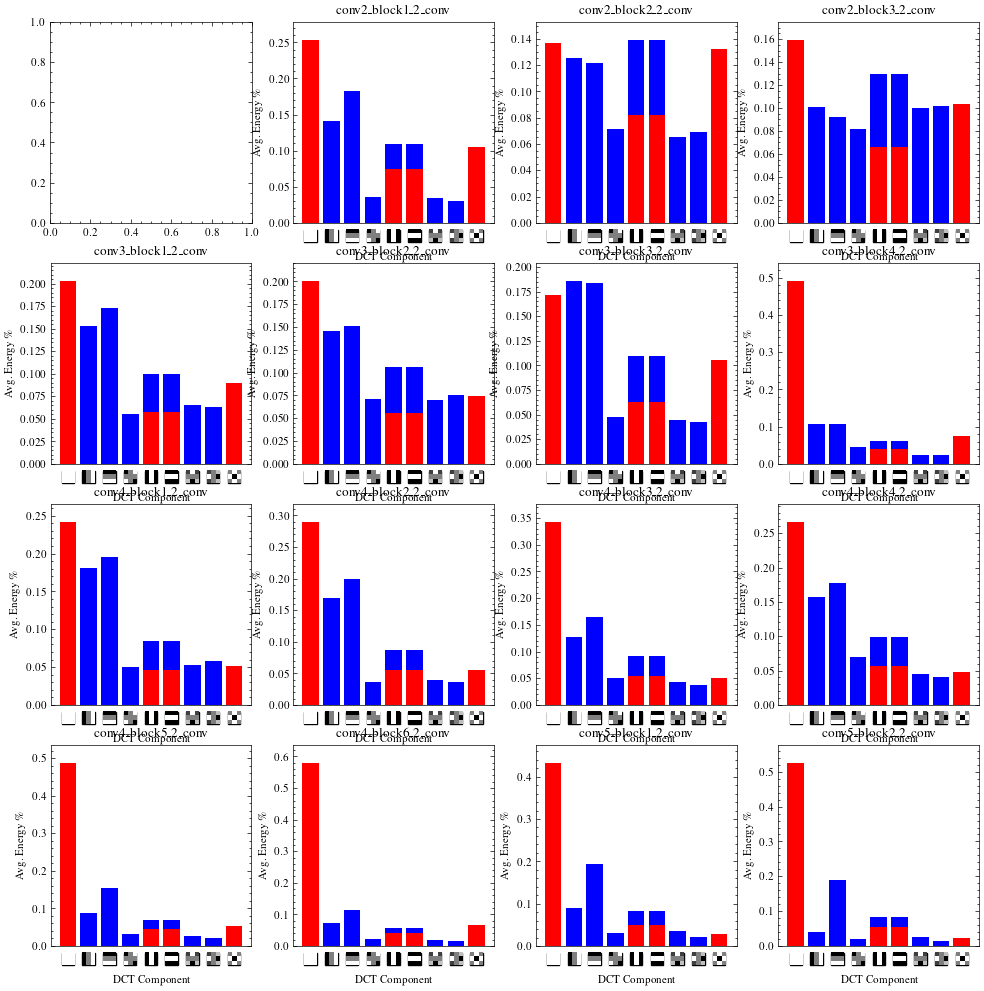

In [ ]:

from matplotlib.offsetbox import OffsetImage, AnnotationBbox


#bars =  ax.bar(["dc", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8"], vals)
pos = [(0,0) , (0,1), (1,0), (1,1), (0, 2) , (2, 0), (1,2), (2,1), (2,2) ]

d = []
for  i,j in pos:
	t = np.zeros((3,3))
	t[i,j] =1
	d.append(tf.reshape(fft.idctn(t, norm='ortho'), (3,3,1,1)))
d = tf.cast(tf.stack(d), dtype=tf.float64)

fig,axs= plt.subplots(nrows=4, ncols=4,figsize=(12, 12))
axs = axs.ravel()

for l_num in range(0, 16):
	if l_num == -1:
		f = np.random.normal(0,1, size=(3,3,100,100)).astype('float64')
		title = "Random"
	else:
		f = get_filter(model, l_num)
		title = conv_layers[l_num].name

	f = tf.cast(f, dtype=tf.float64)

	s, a = getSymAntiSymTF(f)

	# Plot Symmetric part of filters
	ws = tf.reshape(tf.reduce_sum(s.numpy()*d, axis=(1,2)), (d.shape[0],1,1, f.shape[-2], f.shape[-1]))
	#print( tf.reduce_sum(tf.abs(ws), axis=(1,2,3,4))/tf.math.reduce_sum(tf.abs(f)))
	bars =  axs[l_num].bar(["dc", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8"], tf.reduce_sum(ws**2, axis=(1,2,3,4))/tf.math.reduce_sum(f**2), color = "r", label = r"$\beta\leq0.5$ (sym)")
	
	# Plot AntiSymmetric part of filters
	wa = tf.reshape(tf.reduce_sum(a.numpy()*d, axis=(1,2)), (d.shape[0],1,1, f.shape[-2], f.shape[-1]))
	bars =  axs[l_num].bar(["dc", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8"], 
						  tf.reduce_sum(wa**2, axis=(1,2,3,4))/tf.math.reduce_sum(f**2), 
						  color = "b", label=r"$\beta>0.5$ (anti)",
						  bottom=tf.reduce_sum(ws**2, axis=(1,2,3,4))/tf.math.reduce_sum(f**2))

	if l_num == -1:
		legend = axs[l_num].legend(
			loc='lower right',
			prop={'size': 11},
			frameon=True  # make sure the frame is drawn
		)
		frame = legend.get_frame()
		frame.set_facecolor('white')   # solid white background
		frame.set_edgecolor('black')   # black border (optional)
		frame.set_linewidth(0.8)
		frame.set_alpha(1.0)           # fully opaque

	for i, bar in enumerate(bars):
		# Load image

		dct_im = np.zeros((3,3))
		dct_im[pos[i]]=1
		#print(idct2(np.float16(dct_im)))
		img = idct2(np.float16(dct_im))

		# Create OffsetImage object
		im = OffsetImage(img, zoom=3, cmap=plt.cm.binary)  # Adjust zoom for image size

		# Get the x position of the bar's center
		x_position = bar.get_x() + bar.get_width() / 2

		# Place image below the x-axis label
		ab = AnnotationBbox(im, (x_position, 0), 
							xybox=(0, -5),  # Adjust the second value for distance under the label
							xycoords='data', 
							boxcoords="offset points", 
							pad=0, frameon=True, 
							box_alignment=(0.5, 1))

		# Add image to the axes
		axs[l_num].add_artist(ab)
	axs[l_num].set_xticklabels([''] * ws.shape[0])  # Set empty labels
	axs[l_num].set_xlabel('DCT Component')
	axs[l_num].xaxis.set_label_coords(0.5, -0.15)
	axs[l_num].set_ylabel('Avg. Energy \%')

	sym  = (tf.reduce_sum(ws**2, axis=(1,2,3,4)) / tf.reduce_sum(f**2)).numpy()
	anti = (tf.reduce_sum(wa**2, axis=(1,2,3,4)) / tf.reduce_sum(f**2)).numpy()
	stack = sym + anti
	axs[l_num].set_ylim(0, 1.10 * float(stack.max()))  # a little headroom
	axs[l_num].set_box_aspect(1)
	axs[l_num].set_title(title)


	axs[l_num].tick_params(axis='x', which='both', length=0)
axs[-1].set_box_aspect(1)

#fig.delaxes(axs[-1])

fig.tight_layout()
plt.savefig('resnet_dct.pdf', dpi=600)

plt.show()